In [29]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Простейшие алгоритмы поиска корня

In [30]:
def root_dichotomy(f,a,b,e):    # метод деления отрезка пополам
    if (f(a)*f(b) > 0):         # а, b - исследуемый отрезок
        print("error: loaclly convex function")            # e - точность
        return -1
    i = 0
    while (b-a > e):
        i += 1
        c = (b+a)/2
        d = f(a) * f(c)
        if (d < 0):
            b = c
        if d == 0:
            return c
        if (d > 0):
            a = c   
    return a, i

def root_newton(f, df, a, b, e, n):  # метод Ньютона
    i = 1                            # n - ограничение числа итераций
    x = (b+a)/2
    if (f(x) == 0):
        return x
    
    y = x - f(x)/df(x)
    while (np.abs(x-y) > e) and (i < n):
        x = y
        y = x - f(x)/df(x)
        i += 1
    return x, np.abs(x-y), i

def root_system_newton(f,J,x,e, n):  # метод Ньютона для систем
    i = 1                            # J - якобиан отображения f
    if (np.all(f(x) == 0)):
        return x
    
    Jinv = np.linalg.inv(J(x))
    y = x - np.dot(Jinv,f(x))
    while (np.linalg.norm(x-y) > e) and (i < n):
        Jinv = np.linalg.inv(J(x))
        x = y
        y = x - np.dot(Jinv,f(x))
        i += 1
    return x, np.linalg.norm(x-y), i

def root_grad_desc(F, dF, x, n, t): #метод градиентного спуска для F = \f\^2 ищем минимум
    for i in range(n):              #dF - градиент функции F
        if i == n - 1:
            y = x
        x = x - t * dF(x)
        
    return x, F(x), np.linalg.norm(x-y)

# Решение СЛАУ

In [97]:
def eig(A):   #возвращает максимальное собственное значение
    n = len(A)
    x = np.random.randn(n)
    for i in range(100):
        x = np.dot(A, x)
    y = A @ x
    return (np.dot(y,x)/np.dot(x,x))

def criterion(A, f, x, e):     #критерий остановки поиска решения системы Ax = f с точностью e
    if np.linalg.norm(np.dot(A,x)-f) < e:
        return True
    return False

def iter_process_Seid(A, f, U, D, L, x_init, e):  #метод Зейделя
    start_time = time.time()
    R = -np.linalg.inv(L + D)
    F = -np.dot(R,f)
    R = np.dot(R,U)
    x = np.dot(R, x_init) + F
    num_iters = 0
    while(not criterion(A,f,x,e)):
        x = np.dot(R, x) + F
        u = np.dot(A,x)-f
        num_iters += 1
        print ("Номер итерации {0}: норма невязки {1}".format(
                    num_iters, np.linalg.norm(u)))
    print("Заняло {0} сек".format(time.time() - start_time))
    return x

def iter_process_Jac(A, f, U, D, L, x_init, e): #метод Якоби
    start_time = time.time()
    R = np.linalg.inv(D)
    F = np.dot(R,f)
    R = -np.dot(R, L + U)
    x = np.dot(R, x_init) + F
    num_iters = 0
    while(not criterion(A,f,x,e)):
        x = np.dot(R, x) + F
        u = np.dot(A,x)-f
        num_iters += 1
        if (num_iters % 5 == 0):
            print ("Номер итерации {0}: норма невязки {1}".format(
                    num_iters, np.linalg.norm(u)))
    print("Заняло {0} сек".format(time.time() - start_time))
    return x

def is_eye(A):          #для проверки итоговой матрицы на единичность
    n = len(A)
    for i in range(n):
        for j in range(n):
            if i == j and A[i,i] == 1:
                continue
            elif i != j and A[i,j] == 0:
                continue
            else: return False
    return True

def gauss(B,g):        #метод Гаусса решения СЛАУ
    start_time = time.time()
    A = B.copy()
    f = g.copy()
    n = len(A)
    for i in range(n):
        temp = A[i,i]
        A[i,:] = A[i,:] / temp
        f[i] = f[i] / temp
        for j in range(i + 1, n):
            temp = A[j,i].copy()
            A[j,:] = A[j,:] - temp * A[i,:]
            f[j] = f[j] - temp * f[i]
    for i in range(n-1,-1,-1):
        for j in range(i-1,-1,-1):
            temp = A[j,i].copy()
            A[j,:] = A[j,:] - temp * A[i,:]
            f[j] = f[j] - temp * f[i]
    print ("Получено решение: {0}".format(is_eye(A)))
    print ("Норма невязки {0}".format(np.linalg.norm(np.dot(B,f) - g)))
    print ("Заняло {0} сек".format(time.time() - start_time))
        
    return f

def gauss_inv(B):             #обращение матрицы
    start_time = time.time()
    A = B.copy()
    n = len(A)
    C = np.eye(n)
    for i in range(n):
        temp = A[i,i]
        A[i,:] = A[i,:] / temp
        C[i,:] = C[i,:] / temp
        for j in range(i + 1, n):
            temp = A[j,i].copy()
            A[j,:] = A[j,:] - temp * A[i,:]
            C[j,:] = C[j,:] - temp * C[i,:]
    for i in range(n-1,-1,-1):
        for j in range(i-1,-1,-1):
            temp = A[j,i].copy()
            A[j,:] = A[j,:] - temp * A[i,:]
            C[j,:] = C[j,:] - temp * C[i,:]
    print ("Полученная матрица является обратной: {0}".format(is_eye(A)))
    print ("Заняло {0} сек".format(time.time() - start_time))
        
    return C

# Примеры

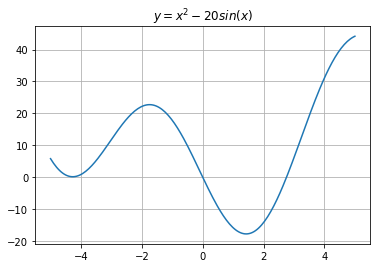

In [71]:
def f(x):
    return x**2 - 20 * np.sin(x)
def df(x):
    return 2*x - 20 * np.cos(x)

plt.title(r'$y = x^2 - 20sin(x)$')
plt.grid()

x = np.linspace(-5,5 , 200)
y = f(x)
plt.plot(x, y)
plt.show()

3 корня, локализованных на отрезках:<br>
1) (-5;-3)<br>
2) (-1;1)<br>
3) (2;4)<br>

Первый корень лежит на (-5;-3):

In [72]:
root_newton(f,df, -5,-3,10**(-5), 50)

(-1.0064231683416325e-10, 1.006423168336568e-10, 15)

In [73]:
root_dichotomy(f, -5, -3, 10**(-5))

error: loaclly convex function


-1

Метод Ньютона сошёлся к 0<br>
Метод деления отрезка пополам не работает<br>
Можно применить метод градиентного спуска:

In [74]:
t = 0.01
x = -4
for i in range(20):
    x = x - df(x) * t
y = x
x = x - df(x) * t
x, np.abs(x-y), f(x)

(-4.268441510587997, 0.0006663529476220731, 0.15832822395480406)

$Таким\  образом,\  корень\  равен\ -4.268 \pm0.001$

Второй корень лежит на (-1;1):

In [75]:
root_newton(f,df, -1,1.01,10**(-5), 50)

(-1.2923288810178651e-06, 1.2923287975128986e-06, 2)

In [76]:
root_dichotomy(f, -1, 1.05, 10**(-5))

(-9.536743163845871e-07, 18)

Оба метода сходтся к 0; метод Ньютона гораздо быстрее<br>
Третий корен лежит на (2;4):

In [77]:
root_newton(f,df, 2,4,10**(-5), 50)

(2.7529466338446347, 2.5929480784725456e-11, 4)

In [78]:
root_dichotomy(f, 2, 4, 10**(-5))

(2.7529449462890625, 18)

Оба метода сходятся к 2.75294

# Пример в плоскости

In [79]:
def f1(x,y):
    return 2*x**2 - x*y -5*x + 1
def f2(x,y):
    return x + 3 * np.log(x)/np.log(10) - y**2

def F(x):
    return f1(x[0],x[1])**2 + f2(x[0],x[1])**2
f1x = lambda x,y: 4*x - y - 5
f1y = lambda x,y: -x
f2x = lambda x,y: 1 + 3/np.log(10)/x
f2y = lambda x,y: -2*y
Fx = lambda x,y: 2 * f1(x,y) * f1x(x,y) + 2 * f2(x,y) * f2x(x,y)
Fy = lambda x,y: 2 * f1(x,y) * f1y(x,y) + 2 * f2(x,y) * f2y(x,y)

def dF(x):
    return np.array([Fx(x[0],x[1]), Fy(x[0],x[1])])
def f(x):
    return np.array([f1(x[0],x[1]),f2(x[0],x[1])])
def J(x):
    return np.array([[f1x(x[0],x[1]),f1y(x[0],x[1])],[f2x(x[0],x[1]),f2y(x[0],x[1])]])

Решать будем методом Ньютона и методом градиентного спуска для функционала F:

In [80]:
root_system_newton(f,J,np.array([30.05,40.05]),0.001, 100)

(array([3.48749633, 2.26171656]), 0.00010272383936412622, 12)

In [81]:
x = np.array([3,1])
root_grad_desc(F, dF, x, 20, 0.01)

(array([3.40814384, 2.16112364]), 0.14310008762027238, 0.02552945203662448)

Оба метода сошлись:<br>
Метод Ньютона для систем сошёлся к
$
        x=\begin{bmatrix}
            3.487 \\
            2.262 \\
           \end{bmatrix}
\ 
\Delta |x| = 0.0001  $ <br>
Метод градиентного спуска сошёлся к 
$
        x=\begin{bmatrix}
            3.41 \\
            2.16 \\
           \end{bmatrix}
\ 
\Delta |x| = 0.14  $ <br>

In [82]:
root_grad_desc(lambda x: (x - np.cos(x))**2,lambda x: 2 * (x - np.cos(x)) * (1+np.sin(x)), 0.7, 100, 0.1)

(0.7390851332151606, 1.232595164407831e-32, 0.0)

# Пример СЛАУ

In [90]:
a = 10
f = np.arange(1,101)
f = f.astype(float)
D = np.diagflat(np.ones(100) * a)
A = np.copy(D)
L = np.zeros([100,100])
U = np.zeros([100,100])
for i in range(-4,0):
    B = np.ones(100 - np.abs(i))
    L += np.diagflat(B, i)
for i in range (1,5):
    B = np.ones(100 - np.abs(i))
    U += np.diagflat(B, i)
A += U + L

eig_max = eig(A)
eig_min = 1/eig(np.linalg.inv(A))
m = eig_max / eig_min

In [91]:
round(m,3)

2.56

Число обусловленности системы = 2.55 <br>
Матрица системы симметрична и положиетльно определена, таким образом метод Зейделя сходится<br>
Метод Якоби тоже сходится, так как имеется диагональное преобладание<br>
Критерием остановки итерационного процесса служит условие: норма невязки меньше eps

In [92]:
x_Jac = iter_process_Jac(A, f, U, D, L, np.ones(len(f)), 0.00001)

Номер итерации 5: норма невязки 100.51063125372335
Номер итерации 10: норма невязки 31.116924132569853
Номер итерации 15: норма невязки 9.73232650987516
Номер итерации 20: норма невязки 3.06113104930254
Номер итерации 25: норма невязки 0.9664045195830628
Номер итерации 30: норма невязки 0.3059194349495573
Номер итерации 35: норма невязки 0.09704238863563602
Номер итерации 40: норма невязки 0.030835375518754825
Номер итерации 45: норма невязки 0.009811833351205173
Номер итерации 50: норма невязки 0.0031259087306904614
Номер итерации 55: норма невязки 0.0009969200535027978
Номер итерации 60: норма невязки 0.0003182355777071668
Номер итерации 65: норма невязки 0.00010167108265379529
Номер итерации 70: норма невязки 3.250642969619251e-05
Номер итерации 75: норма невязки 1.0399969921410394e-05
Заняло 0.04100227355957031 сек


In [93]:
x_Seid = iter_process_Seid(A, f, U, D, L, np.ones(len(f)), 0.00001)

Номер итерации 1: норма невязки 35.593152346261995
Номер итерации 2: норма невязки 10.171111176101329
Номер итерации 3: норма невязки 2.908136951542117
Номер итерации 4: норма невязки 0.8317560575931394
Номер итерации 5: норма невязки 0.23792093684503723
Номер итерации 6: норма невязки 0.06805300697023561
Номер итерации 7: норма невязки 0.01946098664148281
Номер итерации 8: норма невязки 0.0055630156108933135
Номер итерации 9: норма невязки 0.0015893132708030703
Номер итерации 10: норма невязки 0.0004537202183143384
Номер итерации 11: норма невязки 0.00012941051127321105
Номер итерации 12: норма невязки 3.687014140426225e-05
Номер итерации 13: норма невязки 1.0491082254769499e-05
Номер итерации 14: норма невязки 2.980682757026389e-06
Заняло 0.03198862075805664 сек


In [98]:
x_gauss = gauss(A,f)

Получено решение: True
Норма невязки 6.600366920924198e-14
Заняло 0.08600544929504395 сек


Все работает!